In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive', True)
DRIVE_PATH = '/content/gdrive/My\ Drive/cs182/RL-proj'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
# if not os.path.exists(DRIVE_PYTHON_PATH):
#   %mkdir $DRIVE_PATH

# drive.mount('/content/gdrive/My\ Drive/cs182/RL-proj', True)
# DRIVE_PATH = '/content/gdrive/My\ Drive/cs182/RL-proj'
# DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
# if not os.path.exists(DRIVE_PYTHON_PATH):
#   %mkdir $DRIVE_PATH

# the space in `My Drive` causes some issues,
# make a symlink to avoid this
# SYM_PATH = '/content/cs182/RL-proj'
# if not os.path.exists(SYM_PATH):
#   !ln -s $DRIVE_PATH $SYM_PATH

SYM_PATH = DRIVE_PYTHON_PATH

Mounted at /content/gdrive


In [ ]:
os.listdir(DRIVE_PYTHON_PATH + "/log")

['baselines', 'PPO_CNN_10lvl', 'PPO_10lvl', 'PPO_50lvl', 'ACER_50lvl']

In [ ]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz
!pip install procgen
!pip install git+https://github.com/openai/baselines# > ~/pip_install_baselines.log

TensorFlow 1.x selected.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libopenmpi-dev is already the newest version (2.1.1-8).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd6

In [ ]:
import os, time

import gym
import numpy as np
import matplotlib.pyplot as plt

import stable_baselines
from stable_baselines.common.policies import MlpPolicy, CnnPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from stable_baselines import results_plotter
from stable_baselines.bench import Monitor
from stable_baselines import DDPG, TD3, A2C, ACER
from stable_baselines.ddpg.policies import LnMlpPolicy
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.noise import AdaptiveParamNoiseSpec, NormalActionNoise
from stable_baselines.common.callbacks import BaseCallback

stable_baselines.__version__

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



'2.10.0'

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')#f'best_model_{time.strftime("%d%m%y_%H:%M:%S", time.localtime())}' )
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

In [ ]:
params = {"model": "PPO_fancy", "policy": "CNN", "lvls": 100}

title = "{}_{}lvl".format(params["model"], params["lvls"])
log_dir = SYM_PATH + "/log/" + title
os.makedirs(log_dir, exist_ok=True)

log_dir = os.path.join(log_dir, time.strftime("%d%m%y_%H:%M:%S", time.localtime()))
os.makedirs(log_dir, exist_ok=True)

env_param = {"num_levels": params["lvls"], "distribution_mode": "easy"}#, "render_mode": "human"}
env = gym.make("procgen:procgen-fruitbot-v0", **env_param)
env = Monitor(env, log_dir)

# def make_PPO_good(env, params, verbose=0):
# env_name, num_envs, distribution_mode, num_levels, start_level, timesteps_per_proc, is_test_worker=False, log_dir='/tmp/procgen', comm=None
timesteps_per_proc = int(1e4)
learning_rate = 5e-4
ent_coef = .01
gamma = .999
lam = .95
nsteps = 256
nminibatches = 8
ppo_epochs = 3
clip_range = .2
use_vf_clipping = True

conv_fn = lambda x: build_impala_cnn(x, depths=[16,32,32], emb_size=256)

# logger.info("training")
model = ppo2.learn(
    env=env,
    network=conv_fn,
    total_timesteps=timesteps_per_proc,
    save_interval=0,
    nsteps=nsteps,
    nminibatches=nminibatches,
    lam=lam,
    gamma=gamma,
    noptepochs=ppo_epochs,
    log_interval=1,
    ent_coef=ent_coef,
    # mpi_rank_weight=mpi_rank_weight,
    clip_vf=use_vf_clipping,
    # comm=comm,
    lr=learning_rate,
    cliprange=clip_range,
    update_fn=None,
    init_fn=None,
    vf_coef=0.5,
    max_grad_norm=0.5,
)

results_plotter.plot_results([log_dir], 10e6, results_plotter.X_TIMESTEPS, title)
plot_results(log_dir)
    

TypeError: ignored

In [ ]:
import tensorflow as tf
def build_impala_cnn(unscaled_images, depths=[16,32,32], **conv_kwargs):
    """
    Model used in the paper "IMPALA: Scalable Distributed Deep-RL with
    Importance Weighted Actor-Learner Architectures" https://arxiv.org/abs/1802.01561
    """

    layer_num = 0

    def get_layer_num_str():
        nonlocal layer_num
        num_str = str(layer_num)
        layer_num += 1
        return num_str

    def conv_layer(out, depth):
        return tf.layers.conv2d(out, depth, 3, padding='same', name='layer_' + get_layer_num_str())

    def residual_block(inputs):
        depth = inputs.get_shape()[-1].value

        out = tf.nn.relu(inputs)

        out = conv_layer(out, depth)
        out = tf.nn.relu(out)
        out = conv_layer(out, depth)
        return out + inputs

    def conv_sequence(inputs, depth):
        out = conv_layer(inputs, depth)
        out = tf.layers.max_pooling2d(out, pool_size=3, strides=2, padding='same')
        out = residual_block(out)
        out = residual_block(out)
        return out

    out = tf.cast(unscaled_images, tf.float32) / 255.

    for depth in depths:
        out = conv_sequence(out, depth)

    out = tf.layers.flatten(out)
    out = tf.nn.relu(out)
    out = tf.layers.dense(out, 256, activation=tf.nn.relu, name='layer_' + get_layer_num_str())

    return out


# # Custom MLP policy of three layers of size 128 each
# class CustomPolicy(FeedForwardPolicy):
#     def __init__(self, *args, **kwargs):
#         super(CustomPolicy, self).__init__(*args, **kwargs,
#                                            net_arch=[dict(pi=[128, 128, 128],
#                                                           vf=[128, 128, 128])],
#                                            feature_extraction="mlp")

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Num timesteps: 100
Best mean reward: -inf - Last mean reward per episode: -4.00
Saving new best model to /content/cs182/RL-proj/log/test_PPO_2lvl/090521_17:13:57/best_model
Num timesteps: 200
Best mean reward: -4.00 - Last mean reward per episode: -4.00


ValueError: ignored

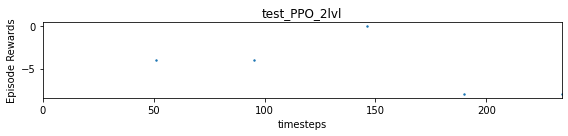

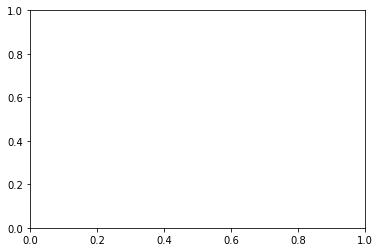

In [ ]:
params = {"model": "test_PPO", "policy": "impalaCNN", "lvls": 2}
n_timesteps = 400
save_freq = 100

title = "{}_{}lvl".format(params["model"], params["lvls"])
log_dir = SYM_PATH + "/log/" + title
os.makedirs(log_dir, exist_ok=True)

log_dir = os.path.join(log_dir, time.strftime("%d%m%y_%H:%M:%S", time.localtime()))
os.makedirs(log_dir, exist_ok=True)

env_param = {"num_levels": params["lvls"], "distribution_mode": "easy"}#, "render_mode": "human"}
env = gym.make("procgen:procgen-fruitbot-v0", **env_param)
env = Monitor(env, log_dir)

callback = SaveOnBestTrainingRewardCallback(check_freq=save_freq, log_dir=log_dir)

# model = models_dict[params["model"]](env, params, verbose=verbose)
model = PPO2(CnnPolicy, env, verbose=0,
                gamma=0.999, n_steps=256, ent_coef=0.01,
                learning_rate=5e-4, vf_coef=0.5, max_grad_norm=0.5,
                lam=0.95, nminibatches=8, noptepochs=3, cliprange=0.2, cliprange_vf=None,
                #verbose=0, tensorboard_log=None, _init_setup_model=True, policy_kwargs=None, full_tensorboard_log=False, seed=None, n_cpu_tf_sess=None))
                policy_kwargs={"cnn_extractor": build_impala_cnn})

model.learn(total_timesteps=int(n_timesteps), callback=callback)

results_plotter.plot_results([log_dir], 10e6, results_plotter.X_TIMESTEPS, title)
plot_results(log_dir)

In [ ]:
def make_PPO(env, params, verbose=0):
    if params.get("policy", "CNN") == "CNN":
        policy = CnnPolicy
    else:
        policy = MlpPolicy
    return PPO2(CnnPolicy, env, verbose=0)

def make_good_PPO(env, params, verbose=0):
    # policy_kwargs = ()
    # depths=, emb_size=256
    return PPO2(CnnPolicy, env, verbose=0,
                gamma=0.999, n_steps=256, ent_coef=0.01,
                learning_rate=5e-4, vf_coef=0.5, max_grad_norm=0.5,
                lam=0.95, nminibatches=8, noptepochs=3, cliprange=0.2, cliprange_vf=None,
                #verbose=0, tensorboard_log=None, _init_setup_model=True, policy_kwargs=None, full_tensorboard_log=False, seed=None, n_cpu_tf_sess=None))
                policy_kwargs={"cnn_extractor": build_impala_cnn})

def make_ACER(env, params, verbose=0):
    if params.get("policy", "CNN") == "CNN":
        policy = CnnPolicy
    else:
        policy = MlpPolicy
    return ACER(CnnPolicy, env, verbose=0)

models_dict = {"good_PPO": make_good_PPO, "PPO": make_PPO, "ACER": make_ACER}

In [ ]:
# params = {"model": "PPO", "policy": "CNN", "lvls": 10}

def train_model(params, n_timesteps, save_freq=2000, verbose=0):
    title = "{}_{}lvl".format(params["model"], params["lvls"])
    log_dir = SYM_PATH + "/log/" + title
    os.makedirs(log_dir, exist_ok=True)

    log_dir = os.path.join(log_dir, time.strftime("%d%m%y_%H:%M:%S", time.localtime()))
    os.makedirs(log_dir, exist_ok=True)

    env_param = {"num_levels": params["lvls"], "distribution_mode": "easy"}#, "render_mode": "human"}
    old_env = gym.make("procgen:procgen-fruitbot-v0", **env_param)
    env = Monitor(old_env, log_dir)

    callback = SaveOnBestTrainingRewardCallback(check_freq=save_freq, log_dir=log_dir)

    model = models_dict[params["model"]](env, params, verbose=verbose)
    model.learn(total_timesteps=int(n_timesteps), callback=callback)

    results_plotter.plot_results([log_dir], 10e6, results_plotter.X_TIMESTEPS, title)
    plot_results(log_dir)
    return log_dir, model, old_env

In [ ]:
log_dir
os.listdir("/content/cs182/RL-proj/log/")

['test_PPO_2lvl', 'good_PPO_50lvl']

Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: -2.24
Saving new best model to /content/gdrive/My Drive/cs182/RL-proj/log/good_PPO_50lvl/090521_17:52:57/best_model
Num timesteps: 4000
Best mean reward: -2.24 - Last mean reward per episode: -2.09
Saving new best model to /content/gdrive/My Drive/cs182/RL-proj/log/good_PPO_50lvl/090521_17:52:57/best_model
Num timesteps: 6000
Best mean reward: -2.09 - Last mean reward per episode: -2.35
Num timesteps: 8000
Best mean reward: -2.09 - Last mean reward per episode: -2.25
Num timesteps: 10000
Best mean reward: -2.09 - Last mean reward per episode: -1.92
Saving new best model to /content/gdrive/My Drive/cs182/RL-proj/log/good_PPO_50lvl/090521_17:52:57/best_model
Num timesteps: 12000
Best mean reward: -1.92 - Last mean reward per episode: -2.11
Num timesteps: 14000
Best mean reward: -1.92 - Last mean reward per episode: -1.75
Saving new best model to /content/gdrive/My Drive/cs182/RL-proj/log/good_PPO_50lvl/090521_17:5

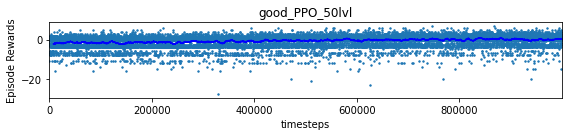

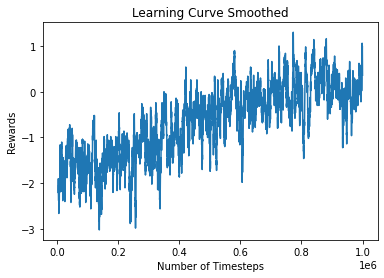

In [ ]:
params = {"model": "good_PPO", "policy": "CNN", "lvls": 50}
log_dir, model, env = train_model(params, 1e6)

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
import time
prev_screen

TypeError: ignored

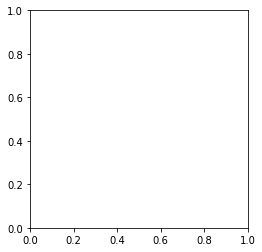

In [ ]:
# env = old_env
obs = env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    # env.render()
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    if dones:
        obs = env.reset()
    # if dones:
    #     env.reset()
    # time.sleep(0.5)
# env.close()
ipythondisplay.clear_output(wait=True)


In [ ]:
dones

True

In [ ]:
params = {"model": "good_PPO", "policy": "CNN", "lvls": 50}
model = make_good_PPO(env, params)
log_dir = '/content/cs182/RL-proj/log/good_PPO_50lvl/080521_06:39:25'
model.load(log_dir + "/best")


In [ ]:
log_dir

'/content/cs182/RL-proj/log/good_PPO_250lvl/080521_07:20:42'










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: -2.40
Saving new best model to /content/cs182/RL-proj/log/good_PPO_250lvl/080521_07:22:53/best_model
Num timesteps: 4000
Best mean reward: -2.40 - Last mean reward per episode: -2.06
Saving new best model to /content/cs182/RL-proj/log/good_PPO_250lvl/080521_07:22:53/best_model
Num timesteps: 6000
Best mean reward: -2.06 - Last mean reward per episode: -1.90
Saving new best model to /content/cs182/RL-proj/log/good_PPO_250lvl/080521_07:22:53/best_model
Num timesteps: 8000
Best mean reward: -1.90 - Last mean reward per episode: -2.01


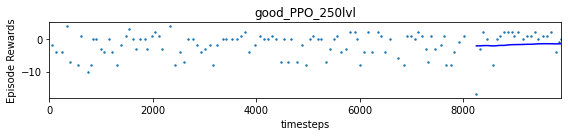

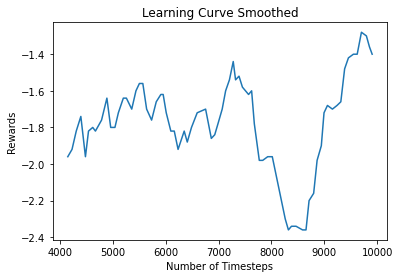

'/content/cs182/RL-proj/log/good_PPO_250lvl/080521_07:22:53'

In [ ]:
params = {"model": "good_PPO", "policy": "CNN", "lvls": 250}
log_dir, model  = train_model(params, 1e4)
log_dir

In [ ]:
params = {"model": "good_PPO", "policy": "CNN", "lvls": 1}
log_dir, model  = train_model(params, 1e6)

In [ ]:
params = {"model": "ACER", "policy": "CNN", "lvls": 250}
train_model(params, 1e6)



Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Num timesteps: 2000
Best mean reward: -inf - Last mean reward per episode: -2.78
Saving new best model to /content/cs182/RL-proj/log/ACER_250lvl/080521_03:00:16/best_model
Num timesteps: 4000
Best mean reward: -2.78 - Last mean reward per episode: -2.51
Saving new best model to /content/cs182/RL-proj/log/ACER_250lvl/080521_03:00:16/best_model
Num timesteps: 6000
Best mean reward: -2.51 - Last mean reward per episode: -2.72
Num timesteps: 8000
Best mean reward: -2.51 - Last mean reward per episode: -2.55
Num timesteps: 10000
Best mean reward: -2.51 - Last mean reward per episode: -2.33
Saving new best model to /content/cs182/RL-proj/log/ACER_250lvl/080521_03:00:16/best_model
Num timesteps: 12000
Best mean reward: -2.33

In [ ]:
log_dir = "/tmp/fruit/TD3"
os.makedirs(log_dir, exist_ok=True)

param = {"num_levels": 1, "distribution_mode": "easy"}#, "render_mode": "human"}
env = gym.make("procgen:procgen-fruitbot-v0", **param)
env = Monitor(env, log_dir)

In [ ]:
# Create action noise because TD3 and DDPG use a deterministic policy
# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
policy_kwargs = dict(layers=[400, 300])
model_td3 = TD3("MlpPolicy", env, buffer_size=int(1e5), policy_kwargs=policy_kwargs, verbose=0) # action_noise=action_noise, 
model_td3.learn(total_timesteps=100000, callback=callback)

AssertionError: ignored

In [ ]:
env.observation_space

Box(0, 255, (64, 64, 3), uint8)

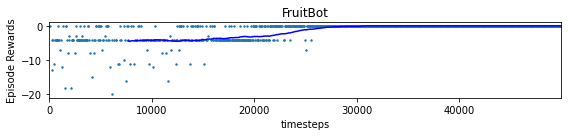

In [ ]:
results_plotter.plot_results([log_dir], 10e6, results_plotter.X_TIMESTEPS, "FruitBot")

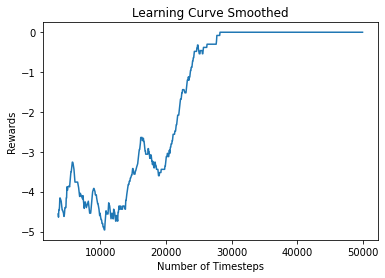

In [ ]:
plot_results(log_dir)

## Import policy, RL agent, Wrappers

In [ ]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines import DDPG, TD3
from stable_baselines.ddpg.policies import LnMlpPolicy
from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.common.noise import AdaptiveParamNoiseSpec, NormalActionNoise
from stable_baselines.common.callbacks import BaseCallback

## Create and wrap the environment

We will be using Lunar Lander environment with continuous actions

In [ ]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('LunarLanderContinuous-v2')
param = {"num_levels": 1, "distribution_mode": "easy"}#, "render_mode": "human"}
env = gym.make("procgen:procgen-fruitbot-v0", **param)
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

## Define and train the DDPG agent

In [ ]:
# Add some param noise for exploration
param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.1, desired_action_stddev=0.1)
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = DDPG(LnMlpPolicy, env, param_noise=param_noise, verbose=0)
# Train the agent
model.learn(total_timesteps=int(1e5), callback=callback)

AssertionError: ignored

## Plotting helpers

Stable Baselines has some built-in plotting helper, that you can find in `stable_baselines.results_plotter`. However, to show how to do it yourself, we are going to use custom plotting functions. 

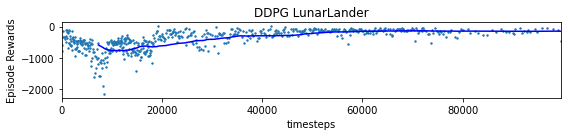

In [ ]:
from stable_baselines import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "DDPG LunarLander")

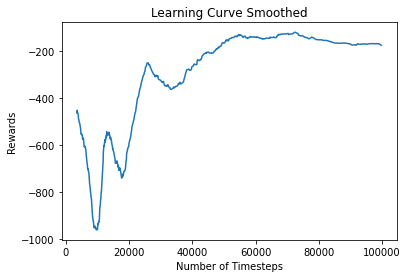

In [ ]:
plot_results(log_dir)

## TD3 vs DDPG

TD3 is the successor of DDPG (cf [Documentation](https://stable-baselines.readthedocs.io/))

In [ ]:
# Create log dir
log_dir = "/tmp/gym/td3/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make('LunarLanderContinuous-v2')
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

In [ ]:
# Create action noise because TD3 and DDPG use a deterministic policy
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
policy_kwargs = dict(layers=[400, 300])
model_td3 = TD3("MlpPolicy", env, action_noise=action_noise, buffer_size=int(1e5), policy_kwargs=policy_kwargs, verbose=0)
model_td3.learn(total_timesteps=14000, callback=callback)

Num timesteps: 80
Best mean reward: -2.61 - Last mean reward per episode: -2.96
Num timesteps: 1080
Best mean reward: -2.61 - Last mean reward per episode: -2.96


KeyboardInterrupt: ignored

In [ ]:
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [ ]:
# Train the agent
model_td3.learn(total_timesteps=14000, callback=callback)

Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -424.17
Saving new best model to /tmp/gym/td3/best_model
Num timesteps: 2000
Best mean reward: -424.17 - Last mean reward per episode: -423.76
Saving new best model to /tmp/gym/td3/best_model
Num timesteps: 3000
Best mean reward: -423.76 - Last mean reward per episode: -382.43
Saving new best model to /tmp/gym/td3/best_model
Num timesteps: 4000
Best mean reward: -382.43 - Last mean reward per episode: -352.77
Saving new best model to /tmp/gym/td3/best_model
Num timesteps: 5000
Best mean reward: -352.77 - Last mean reward per episode: -327.93
Saving new best model to /tmp/gym/td3/best_model
Num timesteps: 6000
Best mean reward: -327.93 - Last mean reward per episode: -309.70
Saving new best model to /tmp/gym/td3/best_model
Num timesteps: 7000
Best mean reward: -309.70 - Last mean reward per episode: -286.04
Saving new best model to /tmp/gym/td3/best_model
Num timesteps: 8000
Best mean reward: -286.04 - Last mean 

ValueError: ignored

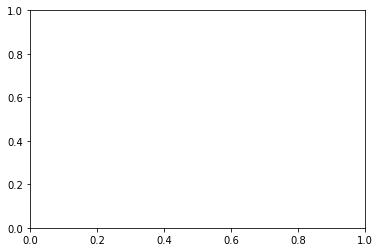

In [ ]:
plot_results(log_dir)

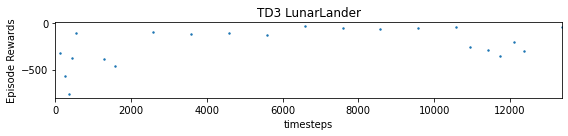

In [ ]:
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "TD3 LunarLander")